In [82]:
# pip install -U memory_profiler

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import random
import enum
import time
from memory_profiler import profile
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


# Задание 1

Решить линейную регрессию — найти прямую, которая описывает зависимость

N - количество осей (размерность) <br>
M - количество точек <br>
minValue - минимальное значение для иксов <br>
maxValue - максимальное значение для иксов

In [84]:
N = 1
M = 30
minValue = 0
maxValue = 5
beta_1 = 0.9
beta_2 = 0.999
batch = random.randint(1, M)

class TypeOfOptimisation(enum.Enum):
    none = 0
    momentum = 1
    Nesterov = 2
    RMSProp = 3
    AdaGrad = 4
    Adam = 5

a = np.array([1, 2])
print(np.sqrt(a))

[1.         1.41421356]


In [85]:
def y_regression(B, X):
    return np.sum(X * B)


B_reg = []
for ind in range(N + 1):
    bi = random.randint(-maxValue, maxValue)
    B_reg.append(bi)
B_reg = np.array(B_reg, dtype='float64')
print(B_reg)
XM = []
YM = []
YR = []
for ind in range(M):
    X = [1]
    for j in range(N):
        X.append(ind)
    X = np.array(X)
    rand_delta = random.randint(-maxValue, maxValue)
    Y_act = y_regression(B_reg, X) + 0.5 * rand_delta
    YM.append(Y_act)
    XM.append(np.array(X))
XM = np.array(XM, dtype='float64')
YM = np.array(YM)

def runSGD(batch, typeOfOptimisation, withNormalization, lr, eps):
    B_start = np.array([0] * (N + 1), dtype='float64')
    YR = np.array([0] * M, dtype='float64')
    global calculations
    start = time.time()
    calculations = 0
    if withNormalization:
        X_norm = ZNormalization(XM)
        Y_norm = (YM - np.mean(YM)) / np.std(YM)
        BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)
        BF_norm, \
        errors_norm, \
        YF_norm, \
        iterations = gradient_descent(batch,
                                      X_norm,
                                      Y_norm,
                                      YR,
                                      B_start,
                                      lr,
                                      eps,
                                      TypeOfOptimisation.none,
                                      with_normalization=True)
        print()
        print("batch:                   ", batch)
        print(errors_norm[0], errors_norm[len(errors_norm) - 1])
        print("actual coefficients:     ", BA_start)
        print("calculated coefficients: ", BF_norm)
        print("number of iterations:    ", iterations)
        print("number of calculations: ", calculations)
        print("execution time: ", (time.time() - start) * 1000, "ms")
        draw_graph(X_norm, Y_norm, YF_norm, batch, withNormalization, typeOfOptimisation)
        draw_errors_graphic(errors_norm, iterations, batch, withNormalization, typeOfOptimisation)
    else:
        B_final, \
        errors, \
        YF, \
        iterations = gradient_descent(batch,
                                      XM,
                                      YM,
                                      YR,
                                      B_start,
                                      lr,
                                      eps,
                                      typeOfOptimisation,
                                      with_normalization=False)
        print()
        print("batch:                   ", batch)
        print(errors[0], errors[len(errors) - 1])
        print("actual coefficients:     ", B_reg)
        print("calculated coefficients: ", B_final)
        print("number of iterations:    ", iterations)
        print("number of calculations: ", calculations)
        print("execution time: ", (time.time() - start) * 1000, "ms")
        draw_graph(XM, YM, YF, batch, withNormalization, typeOfOptimisation)
        draw_errors_graphic(errors, iterations, batch, withNormalization, typeOfOptimisation)


[0. 1.]



batch:                    1
282.48931735685187 15.00907847468378
actual coefficients:      [0. 1.]
calculated coefficients:  [0.04058254 0.80061805]
number of iterations:     77
number of calculations:  156
execution time:  19.843101501464844 ms
peak memory: 123.14 MiB, increment: 1.98 MiB

batch:                    15.0
167.48902743074072 2.1552074065200935
actual coefficients:      [0. 1.]
calculated coefficients:  [0.05078618 1.01394347]
number of iterations:     17
number of calculations:  540
execution time:  6.056308746337891 ms
peak memory: 123.02 MiB, increment: 0.00 MiB

batch:                    30
56.018199782962974 2.154550591446792
actual coefficients:      [0. 1.]
calculated coefficients:  [0.05393849 1.01175237]
number of iterations:     8
number of calculations:  540
execution time:  10.219097137451172 ms
peak memory: 123.03 MiB, increment: 0.00 MiB


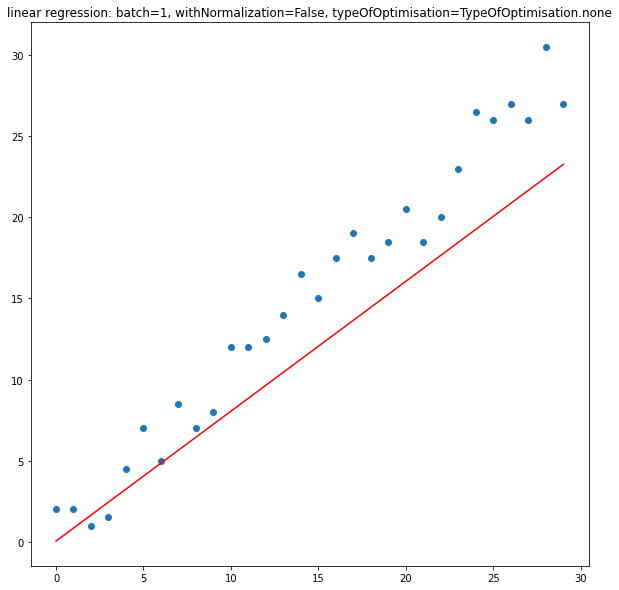

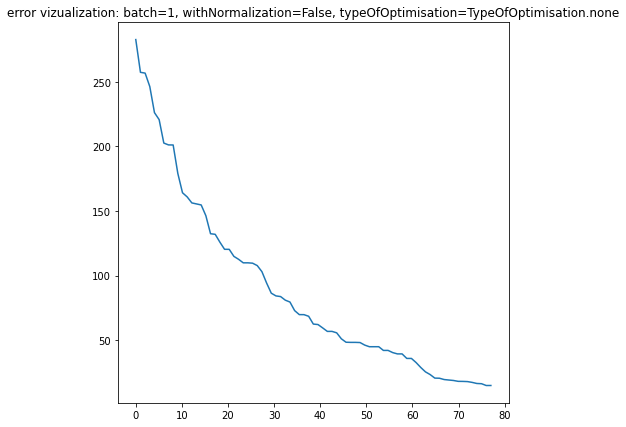

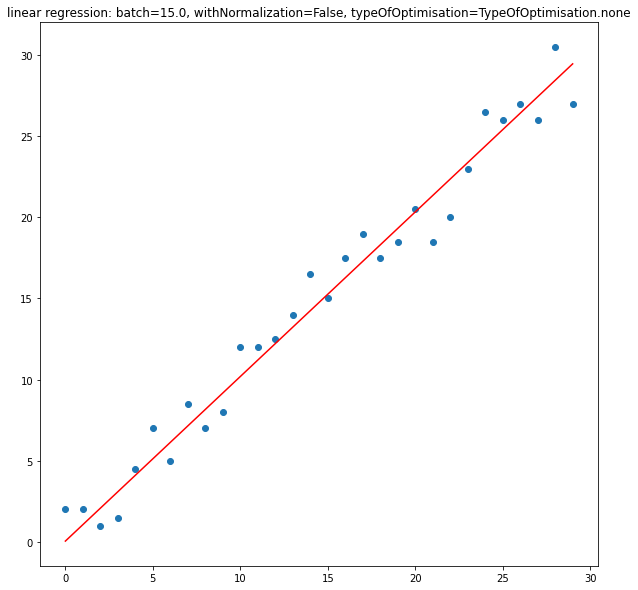

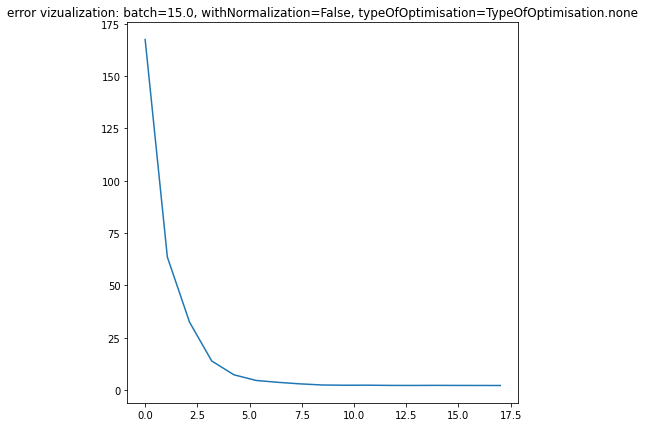

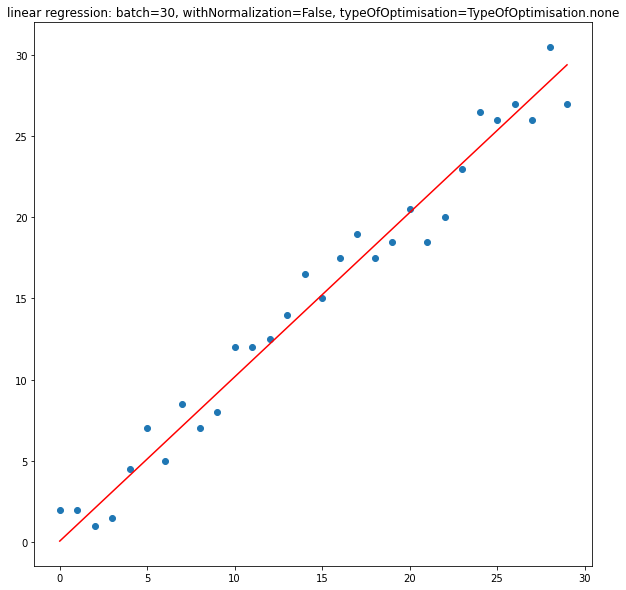

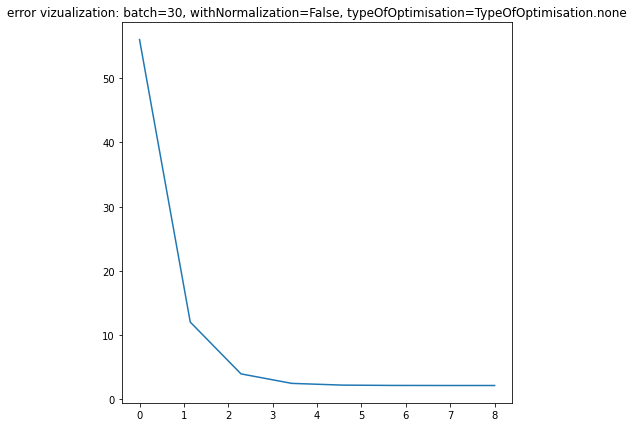

In [86]:
def mean_error(Y_act, Y_reg):
    return np.sum((Y_act - Y_reg)**2) / M


def stopping_criteria(previous, current, eps):
    return abs(previous - current) < eps


def gradient(nums, XM, YR, YM):
    global calculations
    grad = []
    for i in range(N + 1):
        xi = 0
        for k in range(len(nums)):
            xi += XM[nums[k]][i] * (YR[nums[k]] - YM[nums[k]])
            calculations = calculations + 1
            if xi > 1e25:
                return np.array([0] * (N + 1), dtype='float64')
        xi *= 2
        xi /= M
        grad.append(xi)
    return np.array(grad)

def gradient_descent(batch, XM, YM, YR, B_reg, lr, eps, type_of_optimisation, with_normalization):
    # a = [0] * 100000000
    previous_error = 0
    grad = np.array([0] * (N + 1), dtype='float64')
    previous_gradient = np.array([0] * (N + 1), dtype='float64')
    m_adam = np.array([0] * (N + 1), dtype='float64')
    v_adam = np.array([0] * (N + 1), dtype='float64')
    errors = []
    iterations = 0
    global calculations
    while True:
        nums = set()
        while len(nums) != batch:
            x = random.randint(0, M - 1)
            if x not in nums:
                nums.add(x)
        nums = np.array(list(nums))

        # :NOTE: optimisations
        if type_of_optimisation == TypeOfOptimisation.none:
            grad = gradient(nums, XM, YR, YM)
        elif type_of_optimisation == TypeOfOptimisation.momentum:
            grad = gradient(nums, XM, YR, YM)
            grad += gamma * previous_gradient
            calculations = calculations + 1
        elif type_of_optimisation == TypeOfOptimisation.Nesterov:
            B_prev = B_reg - lr * previous_gradient
            YR_new = [0] * M
            for i in range(M):
                YR_new[i] = y_regression(B_prev, XM[i])
            grad = gradient(nums, XM, np.array(YR_new), YM)
            grad += gamma * previous_gradient
            calculations = calculations + 2 + M
        elif type_of_optimisation == TypeOfOptimisation.AdaGrad:
            grad = gradient(nums, XM, YR, YM)
            new_grad = previous_gradient + np.square(grad)
            new_grad = np.divide(grad, np.sqrt(abs(new_grad + eps)))
            grad = new_grad
            calculations = calculations + 2
        elif type_of_optimisation == TypeOfOptimisation.RMSProp:
            grad = gradient(nums, XM, YR, YM)
            new_grad = gamma * previous_gradient + (1 - gamma) * np.square(grad)
            new_grad = np.divide(grad, np.sqrt(abs(new_grad + eps)))
            grad = new_grad
            calculations = calculations + 2
        elif type_of_optimisation == TypeOfOptimisation.Adam:
            grad = gradient(nums, XM, YR, YM)
            m_adam = beta_1 * m_adam + (1 - beta_1) * grad
            v_adam = beta_2 * v_adam + (1 - beta_2) * np.square(grad)
            m = m_adam / (1 - beta_1)
            v = v_adam / (1 - beta_2)
            grad = m / np.sqrt(abs(v + eps))
            calculations = calculations + 5
        B_reg -= lr * grad

        for i in range(M):
            YR[i] = y_regression(B_reg, XM[i])
        if stopping_criteria(previous_error, mean_error(YM, YR), eps):
            break
        previous_error = mean_error(YM, YR)
        previous_gradient = grad
        errors.append(previous_error)
        iterations += 1
    return B_reg, errors, YR, iterations


def draw_graph(XM, YM, YF, batch, withNormalization, typeOfOptimisation):
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    X = XM.T[1]
    plt.scatter(X, YM)
    plt.plot(X, YF, color='red')
    title = 'linear regression: batch=' + str(batch) + \
            ', withNormalization=' + str(withNormalization) + \
            ', typeOfOptimisation=' + str(typeOfOptimisation)
    plt.title(title)
    plt.show()


def draw_errors_graphic(E, iterations, batch, withNormalization, typeOfOptimisation):
    fig = plt.figure()
    fig.set_size_inches(7, 7)
    i = np.linspace(0, iterations, iterations)
    plt.plot(i, E)
    title = 'error vizualization: batch=' + str(batch) + \
            ', withNormalization=' + str(withNormalization) + \
            ', typeOfOptimisation=' + str(typeOfOptimisation)
    plt.title(title)
    plt.show()

%memit runSGD(1, TypeOfOptimisation.none, withNormalization=False, lr=1e-3, eps=1e-3)
%memit runSGD(M / 2, TypeOfOptimisation.none, withNormalization=False, lr=1e-3, eps=1e-3)
%memit runSGD(M, TypeOfOptimisation.none, withNormalization=False, lr=1e-3, eps=1e-3)

# Задание 2


batch:                    1
0.9932712483950213 0.02803068467070548
actual coefficients:      [-1.  1.]
calculated coefficients:  [0.00430162 0.99984557]
number of iterations:     608
number of calculations:  1218
execution time:  140.81406593322754 ms
peak memory: 124.38 MiB, increment: 3.00 MiB

batch:                    15.0
0.9814955515819487 0.02865491504339824
actual coefficients:      [-1.  1.]
calculated coefficients:  [-0.00583396  0.9577019 ]
number of iterations:     351
number of calculations:  10560
execution time:  92.55290031433105 ms
peak memory: 123.35 MiB, increment: 0.00 MiB

batch:                    30
0.9615016835137705 0.027844849725562927
actual coefficients:      [-1.  1.]
calculated coefficients:  [-5.58072107e-17  9.81135152e-01]
number of iterations:     262
number of calculations:  15780
execution time:  114.35890197753906 ms
peak memory: 123.35 MiB, increment: 0.00 MiB


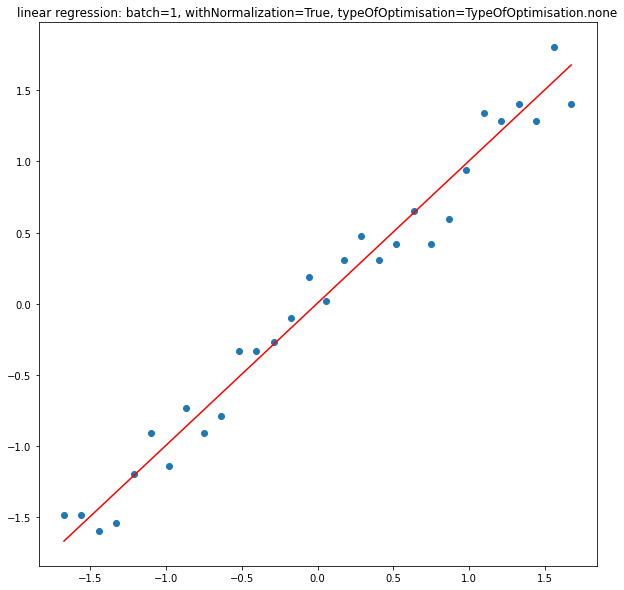

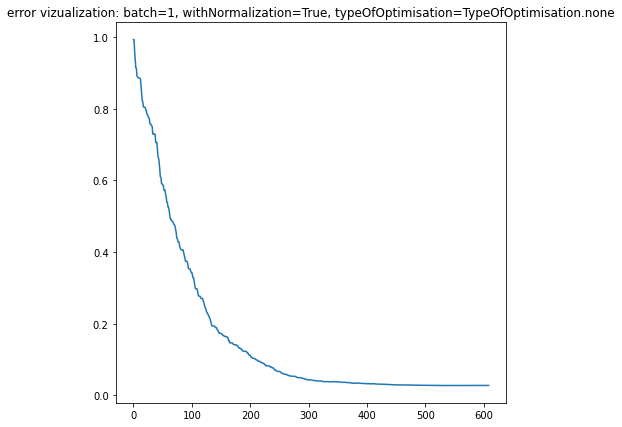

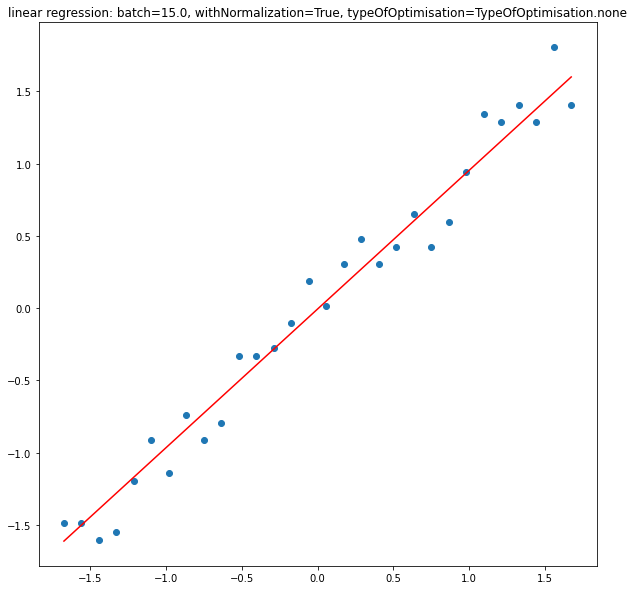

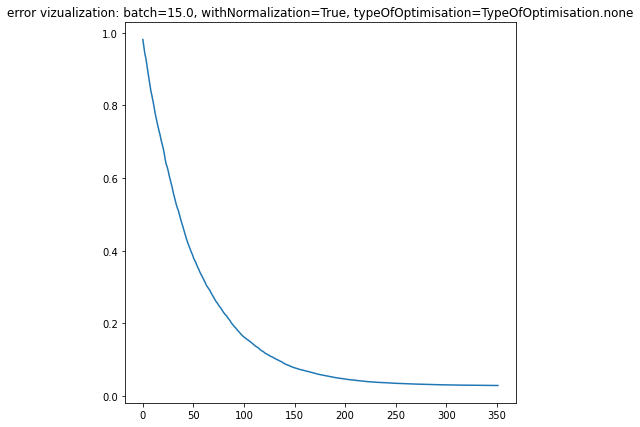

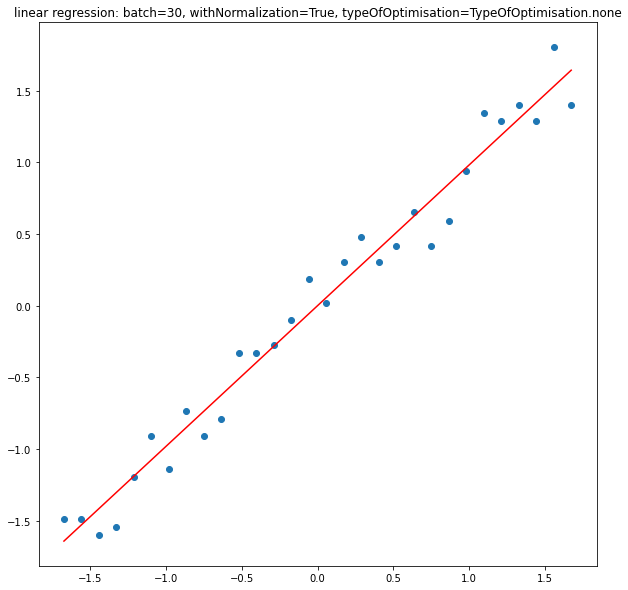

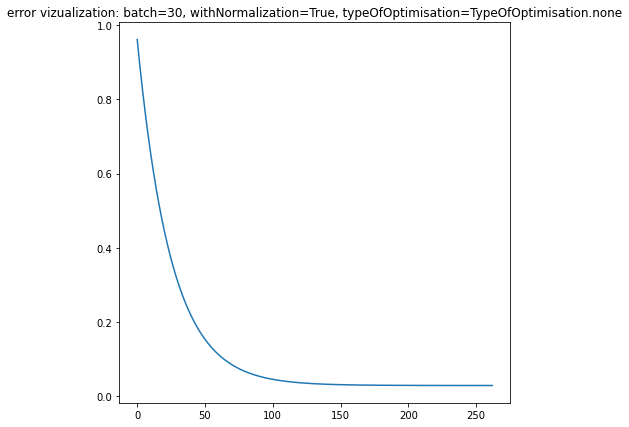

In [94]:
def ZNormalization(XM):
    X = XM.T
    for i in range(1, N + 1):
        X[i] = (X[i] - np.mean(X[i])) / np.std(X[i])
    return X.T


# print(XM)
%memit runSGD(1, TypeOfOptimisation.none, withNormalization=True, lr=1e-1, eps=1e-7)
%memit runSGD(M / 2, TypeOfOptimisation.none, withNormalization=True, lr=1e-2, eps=1e-6)
%memit runSGD(M, TypeOfOptimisation.none, withNormalization=True, lr=1e-2, eps=1e-6)

# Задание 3

### Метод моментов

Смысл заключается в том, что мы на каждом шаге прибавляем к значению градиента
предыдущий градиент умноженный на константу. Это позволяет градиентному спуску не застревать
в локальных минимумах.


batch:                    1
293.4432705969596 2.0898263098786045
actual coefficients:      [0. 1.]
calculated coefficients:  [14.83969487  8.46450022]
number of iterations:     202
number of calculations:  609
execution time:  47.158002853393555 ms
peak memory: 127.18 MiB, increment: 4.95 MiB

batch:                    15.0
249.93078843159066 2.160815358963411
actual coefficients:      [0. 1.]
calculated coefficients:  [14.87598879  8.25733122]
number of iterations:     894
number of calculations:  27745
execution time:  269.0870761871338 ms
peak memory: 128.23 MiB, increment: 3.06 MiB

batch:                    30
190.1476354467927 2.0842438173789333
actual coefficients:      [0. 1.]
calculated coefficients:  [14.87744072  8.54031527]
number of iterations:     112
number of calculations:  6893
execution time:  45.08686065673828 ms
peak memory: 127.34 MiB, increment: 0.00 MiB

batch:                    1
0.9676344410932666 0.028453240022162003
actual coefficients:      [-1.  1.]
calcu

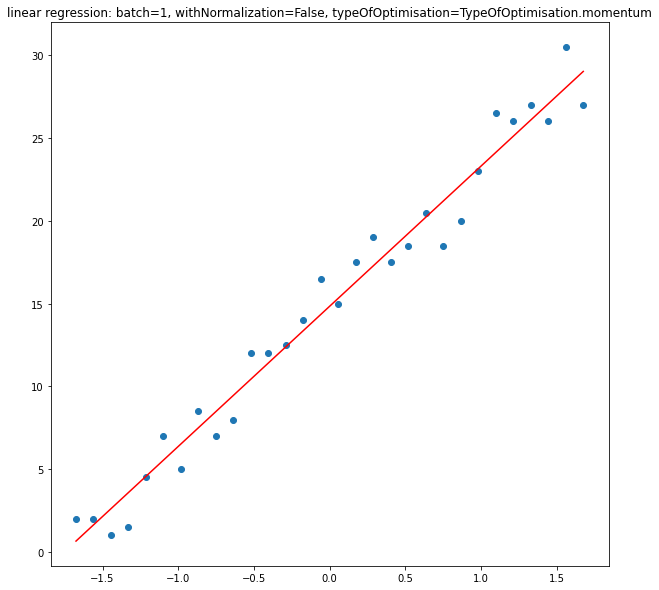

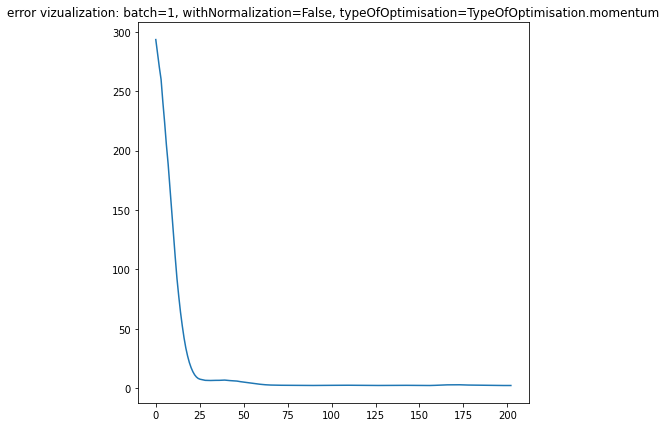

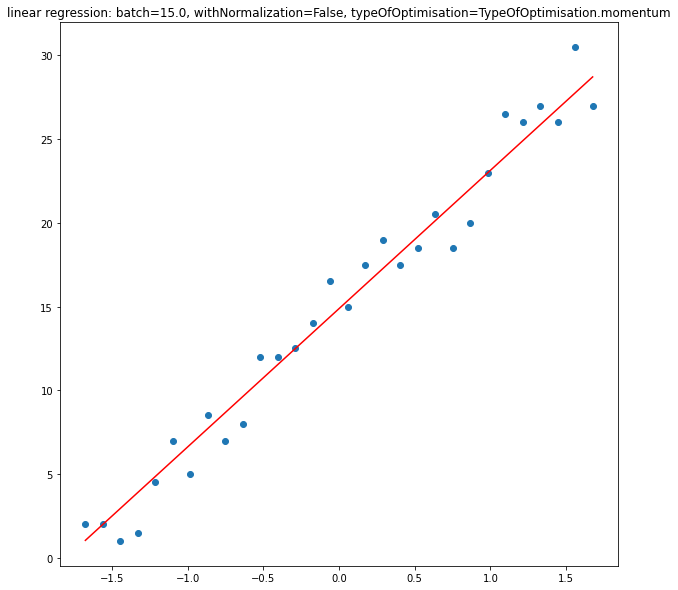

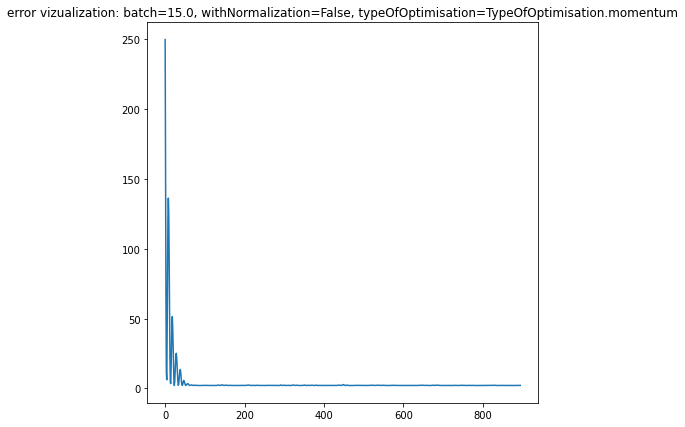

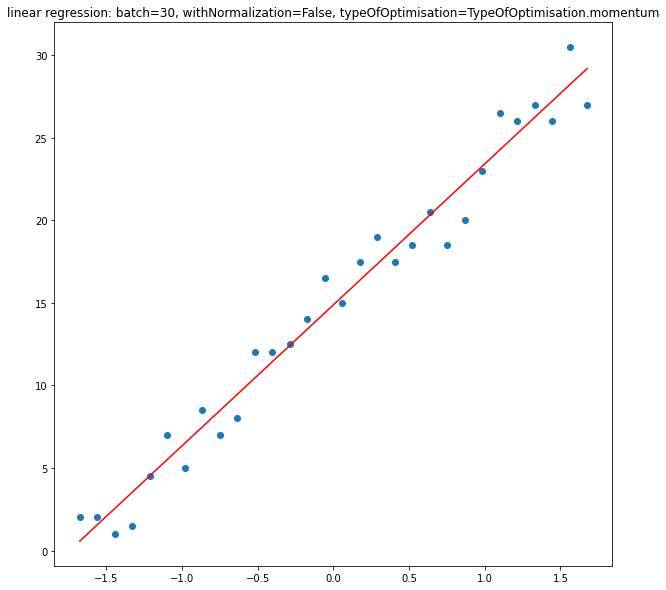

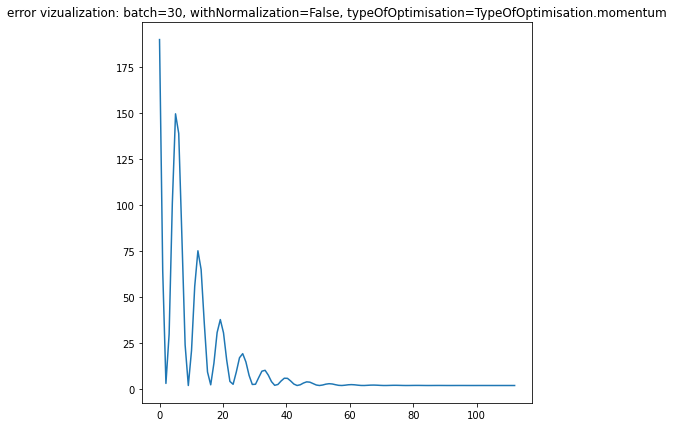

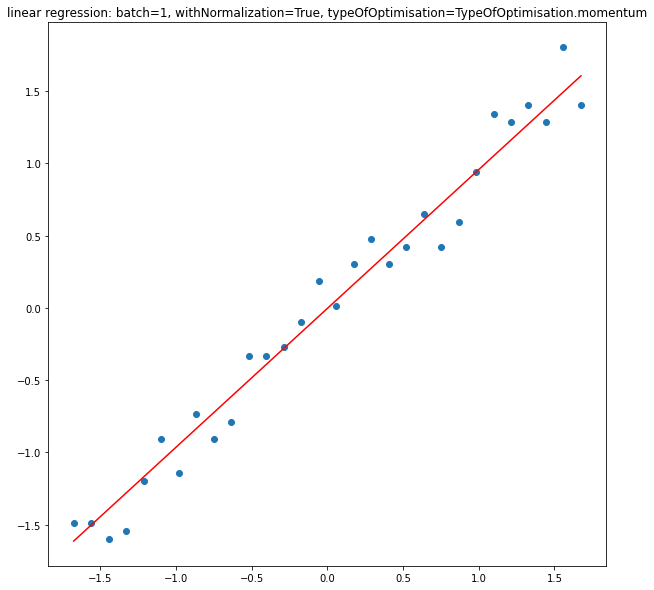

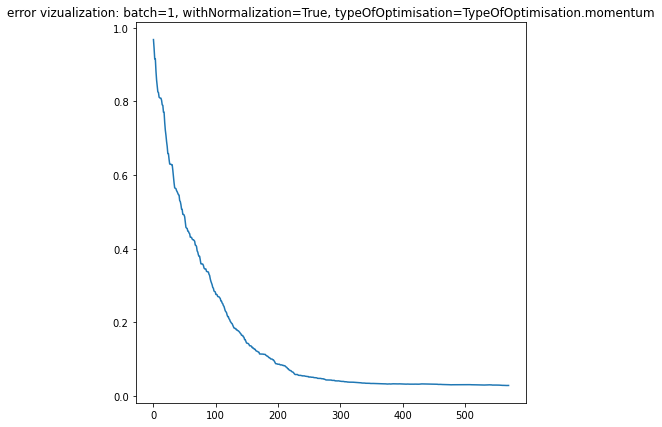

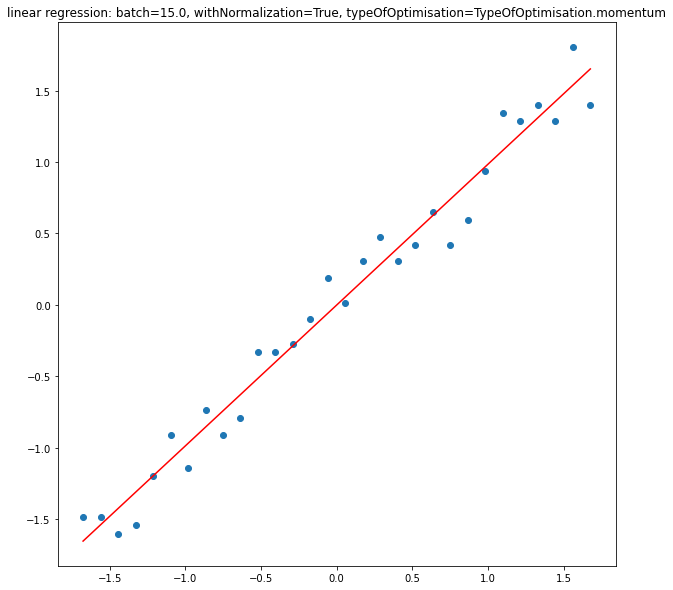

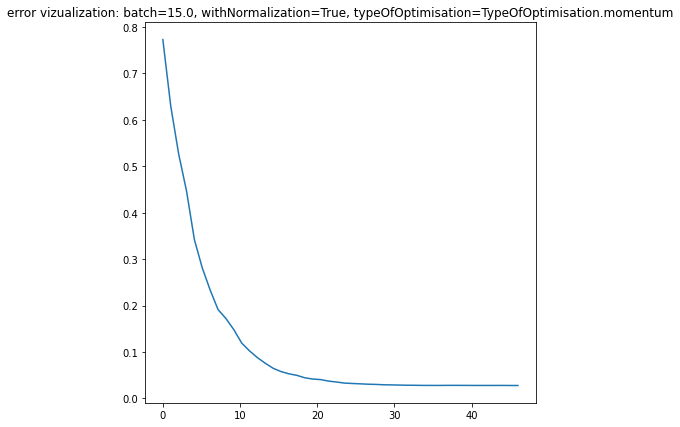

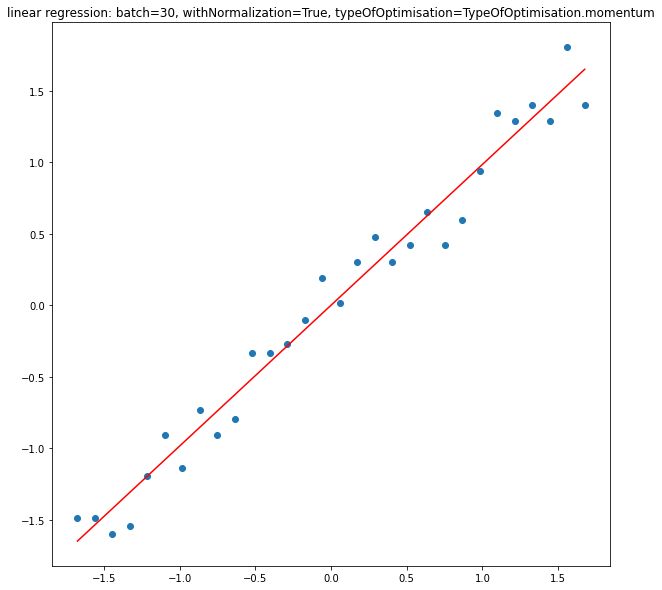

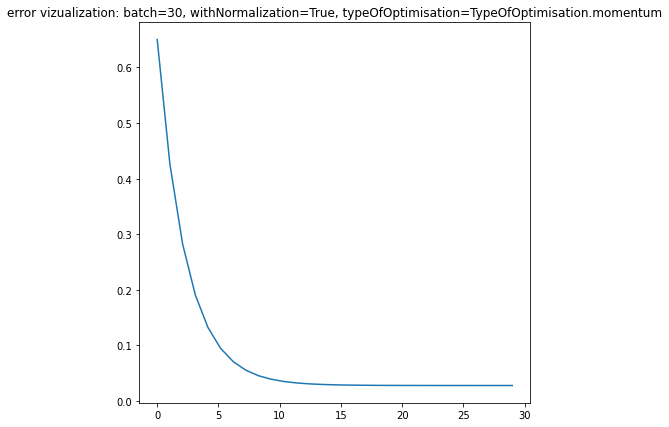

In [95]:
gamma = 0.9

%memit runSGD(1, TypeOfOptimisation.momentum, withNormalization=False, lr=1e-1, eps=1e-4)
%memit runSGD(M / 2, TypeOfOptimisation.momentum, withNormalization=False, lr=1e-1, eps=1e-4)
%memit runSGD(M, TypeOfOptimisation.momentum, withNormalization=False, lr=1e-1, eps=1e-4)
%memit runSGD(1, TypeOfOptimisation.momentum, withNormalization=True, lr=1e-1, eps=1e-7)
%memit runSGD(M / 2, TypeOfOptimisation.momentum, withNormalization=True, lr=1e-1, eps=1e-6)
%memit runSGD(M, TypeOfOptimisation.momentum, withNormalization=True, lr=1e-1, eps=1e-6)

### Метод Нестерова

Здесь используется тот же смысл, как и в методе моментов, только градиент мы считаем не от текущей точки,
а от следующей (как бы заглядывая вперед). Дает более быструю сходимость, чем метод моментов.


batch:                    1
284.61642424916573 2.1081925978835003
actual coefficients:      [0. 1.]
calculated coefficients:  [14.99454736  8.62120836]
number of iterations:     239
number of calculations:  8160
execution time:  99.4100570678711 ms
peak memory: 124.82 MiB, increment: 3.43 MiB

batch:                    15.0
237.8376413793103 2.0846465764614397
actual coefficients:      [0. 1.]
calculated coefficients:  [14.8863664   8.53128193]
number of iterations:     308
number of calculations:  19158
execution time:  136.42001152038574 ms
peak memory: 125.27 MiB, increment: 1.49 MiB

batch:                    30
190.1476354467927 2.084266356794536
actual coefficients:      [0. 1.]
calculated coefficients:  [14.86605803  8.53378109]
number of iterations:     37
number of calculations:  3496
execution time:  22.81808853149414 ms
peak memory: 125.06 MiB, increment: 0.00 MiB

batch:                    1
0.975805422402985 0.02910123879758847
actual coefficients:      [-1.  1.]
calculat

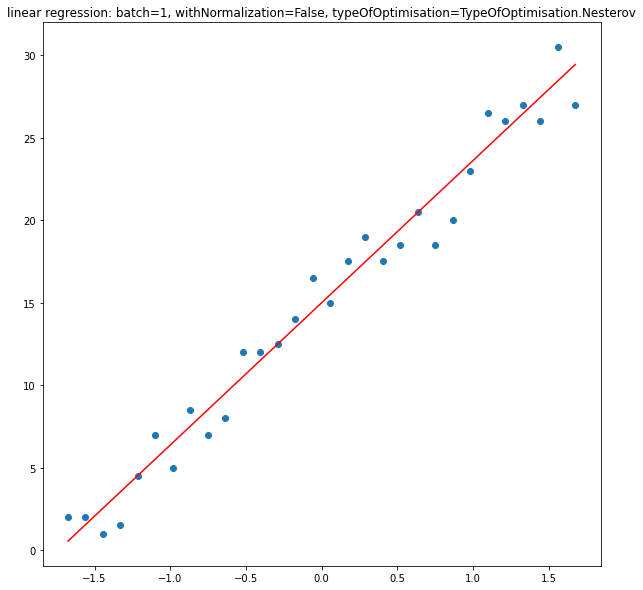

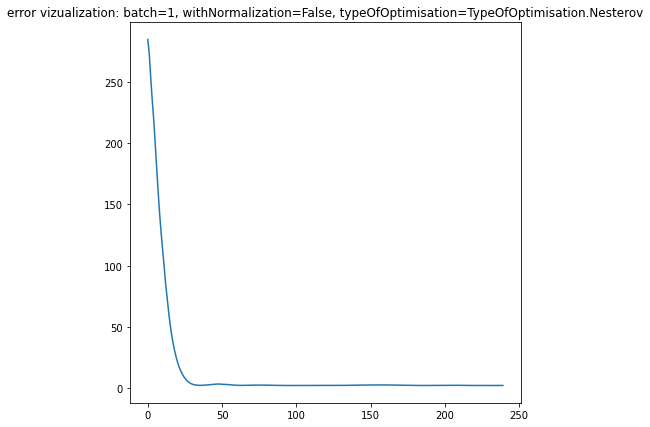

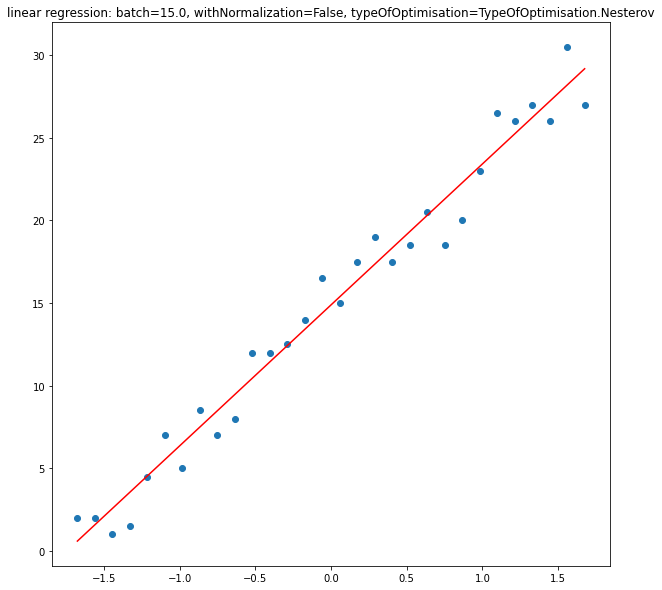

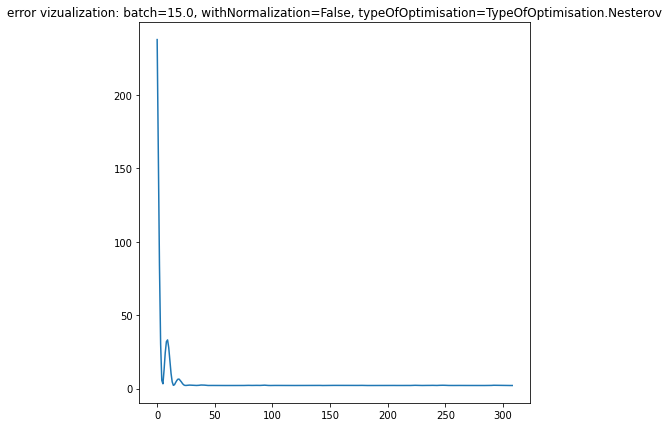

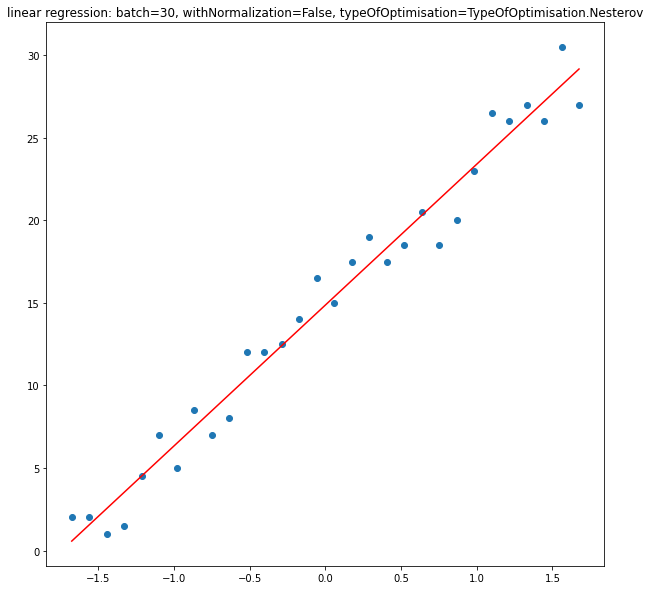

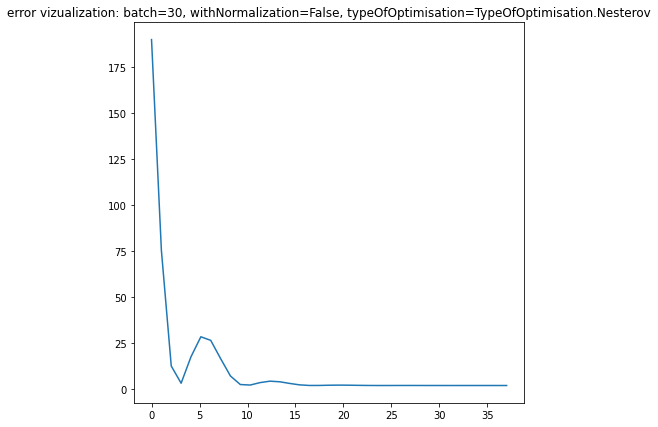

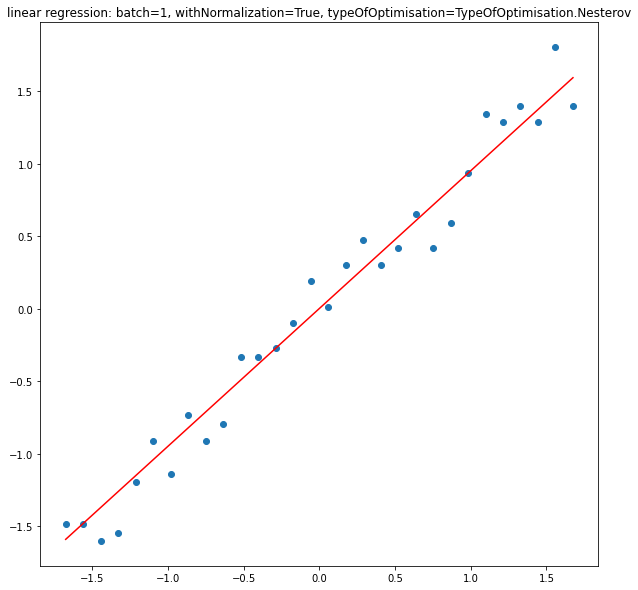

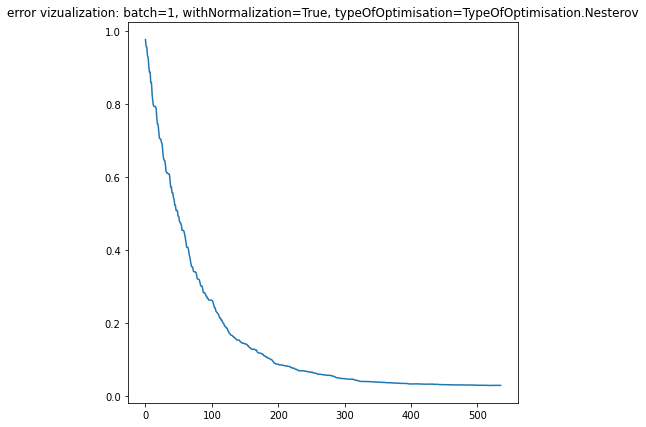

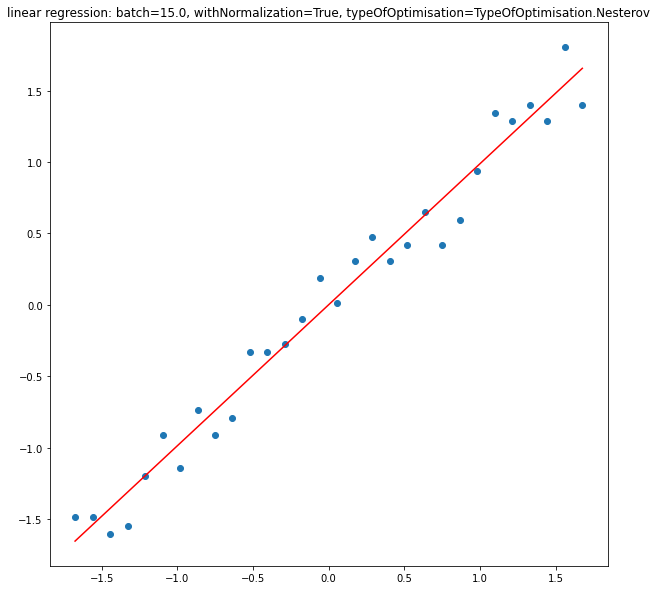

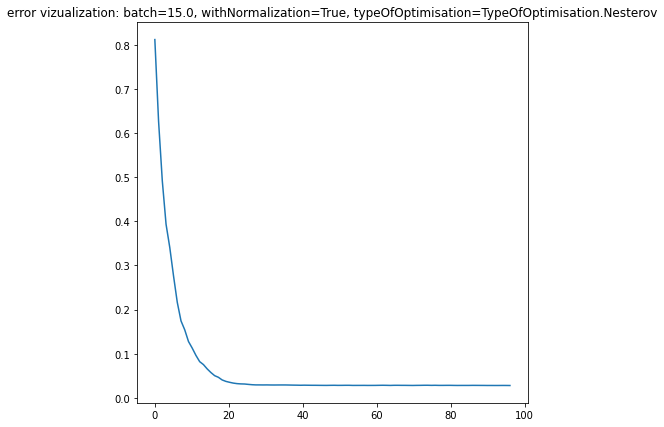

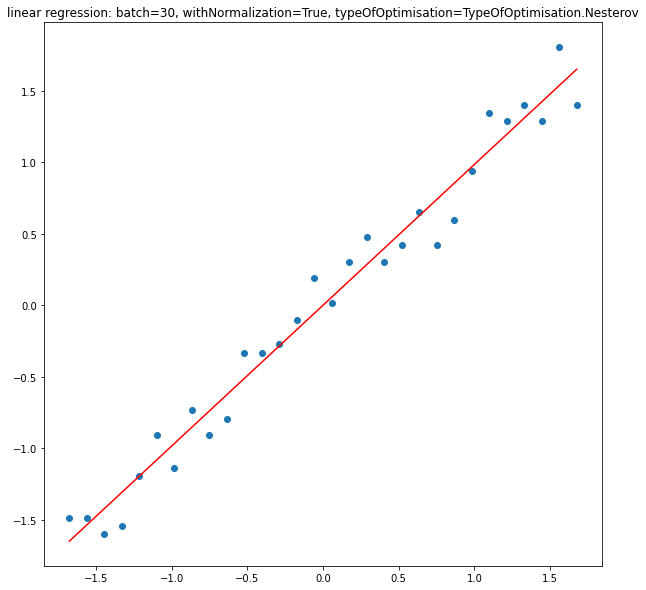

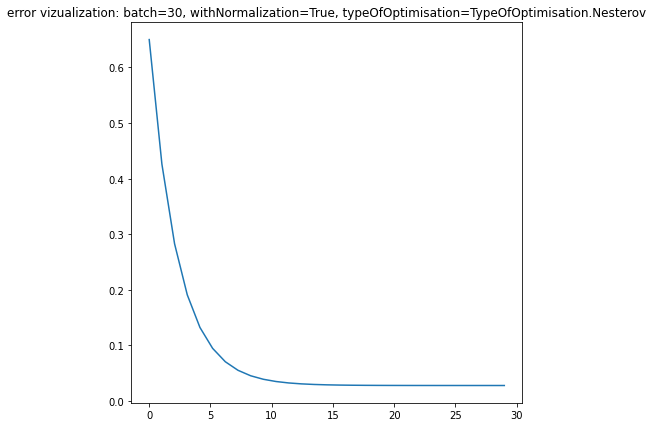

In [96]:
%memit runSGD(1, TypeOfOptimisation.Nesterov, withNormalization=False, lr=1e-1, eps=1e-4)
%memit runSGD(M / 2, TypeOfOptimisation.Nesterov, withNormalization=False, lr=1e-1, eps=1e-4)
%memit runSGD(M, TypeOfOptimisation.Nesterov, withNormalization=False, lr=1e-1, eps=1e-4)
%memit runSGD(1, TypeOfOptimisation.Nesterov, withNormalization=True, lr=1e-1, eps=1e-7)
%memit runSGD(M / 2, TypeOfOptimisation.Nesterov, withNormalization=True, lr=1e-1, eps=1e-6)
%memit runSGD(M, TypeOfOptimisation.Nesterov, withNormalization=True, lr=1e-1, eps=1e-6)

### AdaGrad

Некоторые параметры могут быстрее достигать своего оптимума. То есть те параметры, которые близки к оптимуму,
нужно менять с меньшим шагом, а другие с большим.


batch:                    1
294.68682015246554 2.084384572728223
actual coefficients:      [0. 1.]
calculated coefficients:  [14.85297951  8.52911257]
number of iterations:     786
number of calculations:  3148
execution time:  189.31198120117188 ms
peak memory: 124.93 MiB, increment: 3.04 MiB

batch:                    15.0
291.2731740532528 2.089132561761831
actual coefficients:      [0. 1.]
calculated coefficients:  [14.87078745  8.46382204]
number of iterations:     424
number of calculations:  13600
execution time:  133.48913192749023 ms
peak memory: 124.73 MiB, increment: 1.49 MiB

batch:                    30
291.27317395002297 2.0841763774799764
actual coefficients:      [0. 1.]
calculated coefficients:  [14.86660757  8.5336302 ]
number of iterations:     152
number of calculations:  9486
execution time:  71.07305526733398 ms
peak memory: 124.59 MiB, increment: 0.00 MiB

batch:                    1
0.9634618844468915 0.028733441699446256
actual coefficients:      [-1.  1.]
cal

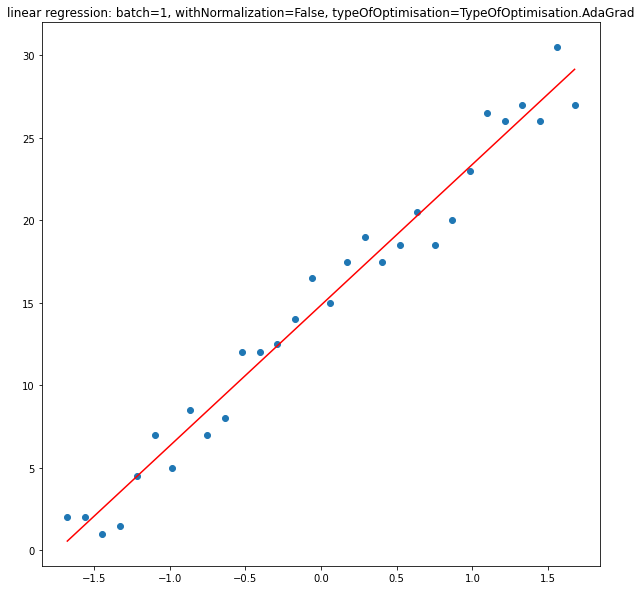

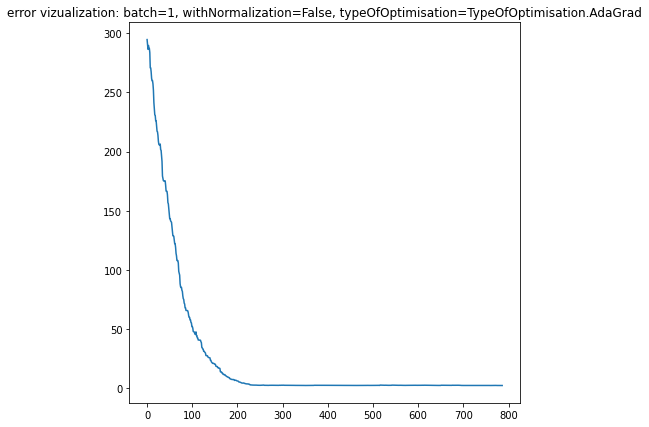

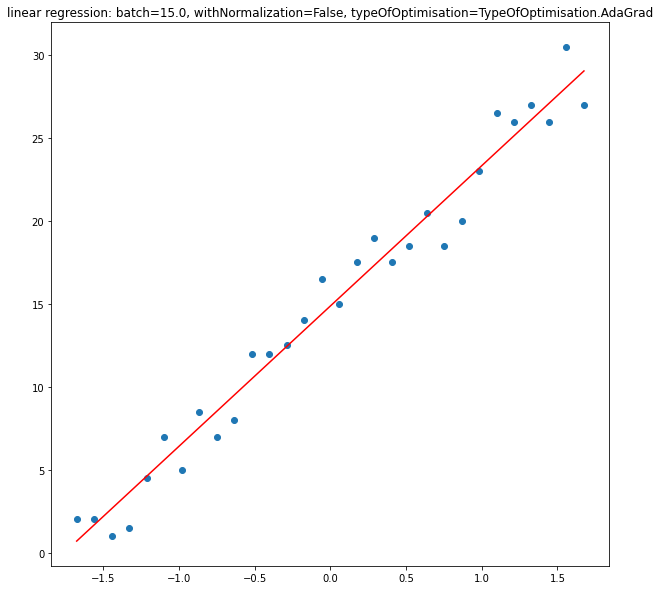

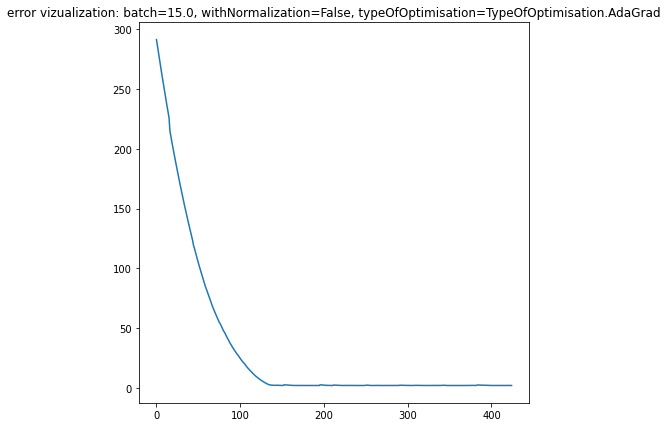

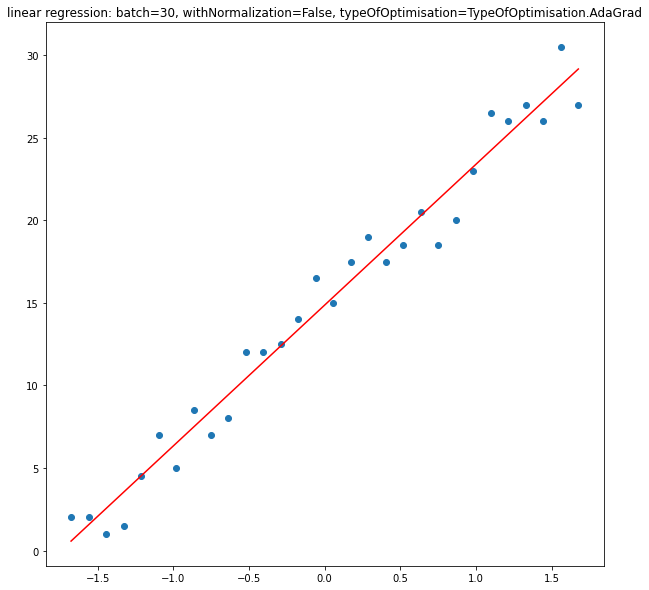

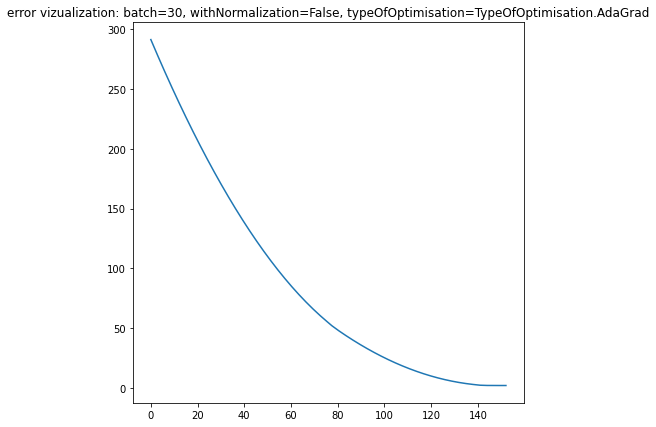

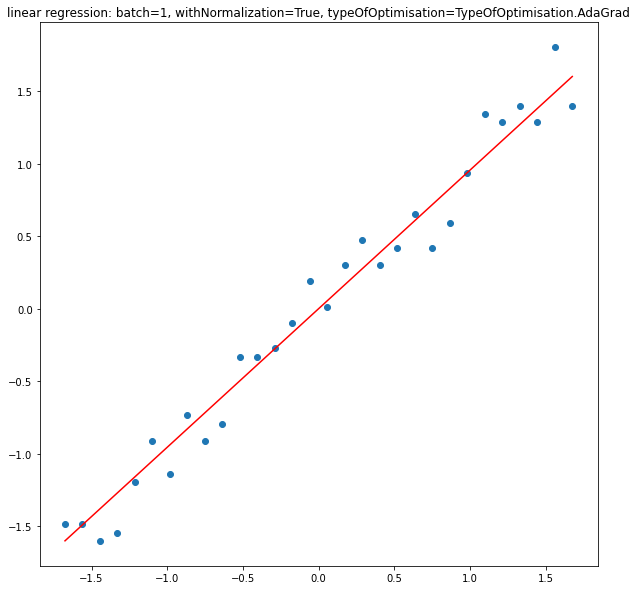

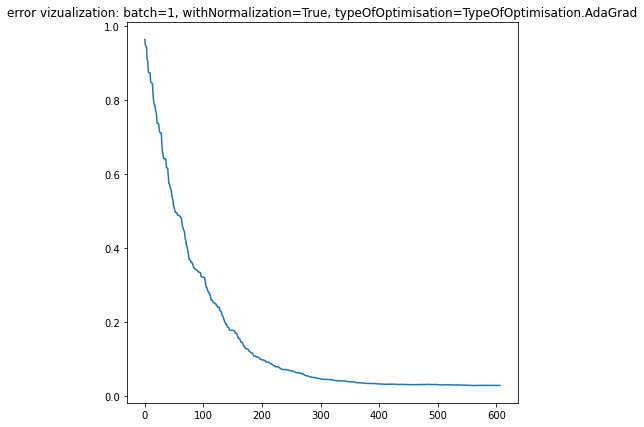

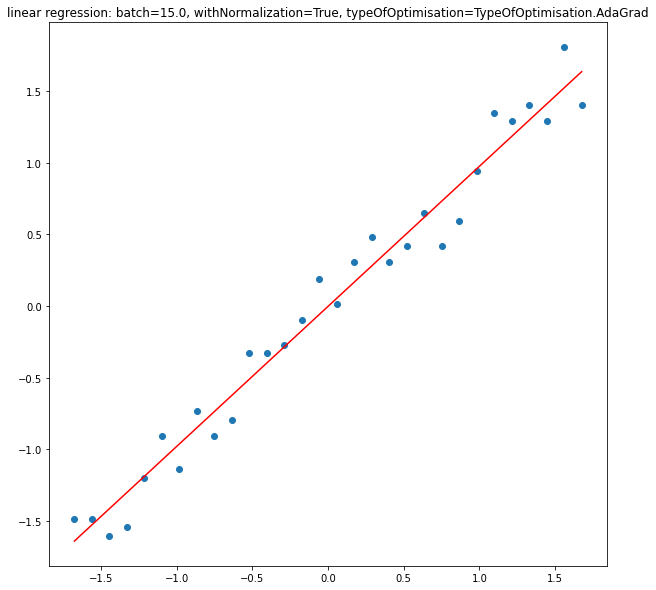

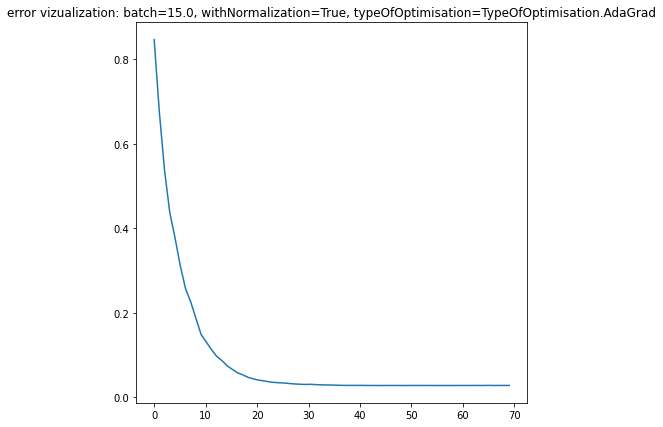

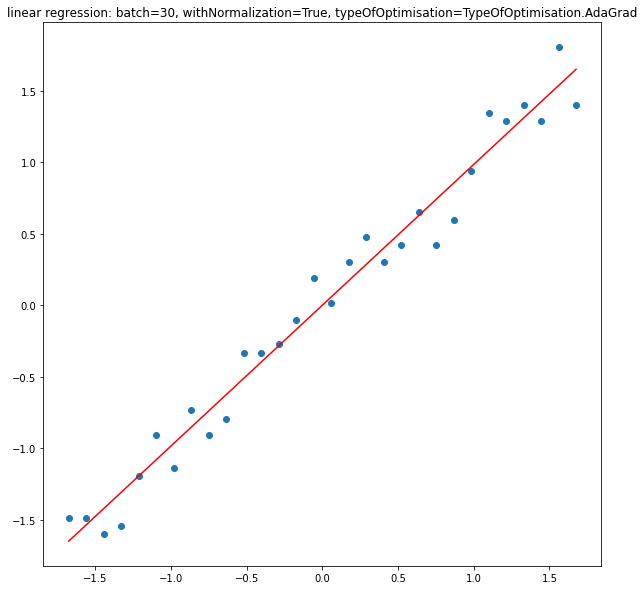

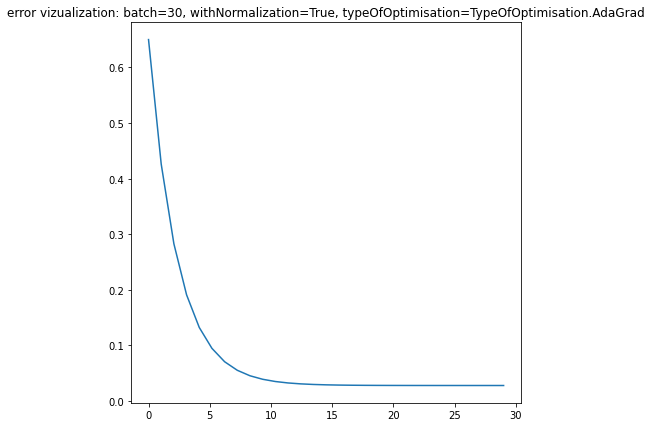

In [97]:
%memit runSGD(1, TypeOfOptimisation.AdaGrad, withNormalization=False, lr=1e-1, eps=1e-6)
%memit runSGD(M / 2, TypeOfOptimisation.AdaGrad, withNormalization=False, lr=1e-1, eps=1e-5)
%memit runSGD(M, TypeOfOptimisation.AdaGrad, withNormalization=False, lr=1e-1, eps=1e-5)
%memit runSGD(1, TypeOfOptimisation.AdaGrad, withNormalization=True, lr=1e-1, eps=1e-7)
%memit runSGD(M / 2, TypeOfOptimisation.AdaGrad, withNormalization=True, lr=1e-1, eps=1e-6)
%memit runSGD(M, TypeOfOptimisation.AdaGrad, withNormalization=True, lr=1e-1, eps=1e-6)

### RMSProp

Идея сохранять не всю историю по квадратам градиеента, а только часть. Использовать дисконтирующий множитель,
чтобы ограничеть действие далеких градиентов, вычесленных давно.


batch:                    1
292.1274678219499 2.085395436146724
actual coefficients:      [0. 1.]
calculated coefficients:  [14.88516523  8.56376288]
number of iterations:     420
number of calculations:  1684
execution time:  196.2602138519287 ms
peak memory: 124.51 MiB, increment: 1.98 MiB

batch:                    15.0
281.3333717827576 2.0866238075609003
actual coefficients:      [0. 1.]
calculated coefficients:  [14.85912939  8.58306106]
number of iterations:     1061
number of calculations:  33984
execution time:  263.36169242858887 ms
peak memory: 125.14 MiB, increment: 1.49 MiB

batch:                    30
281.3333711375909 2.084174604991117
actual coefficients:      [0. 1.]
calculated coefficients:  [14.86672214  8.53357463]
number of iterations:     52
number of calculations:  3286
execution time:  23.142099380493164 ms
peak memory: 124.94 MiB, increment: 0.00 MiB

batch:                    1
0.9977424533179975 0.028417146422599564
actual coefficients:      [-1.  1.]
calcu

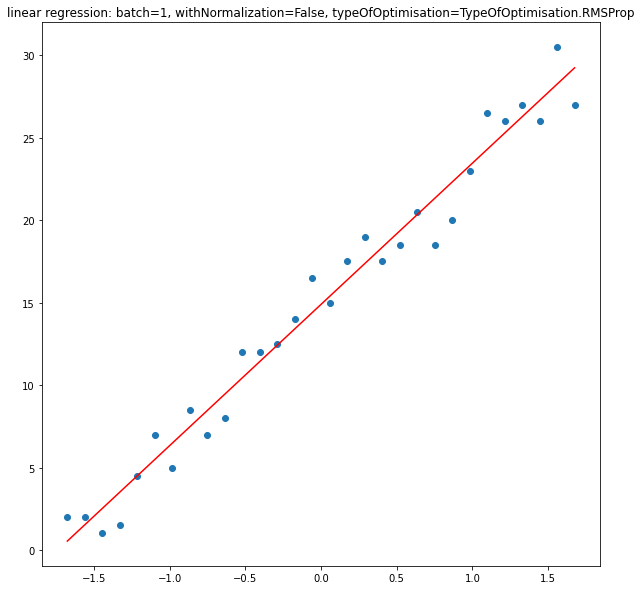

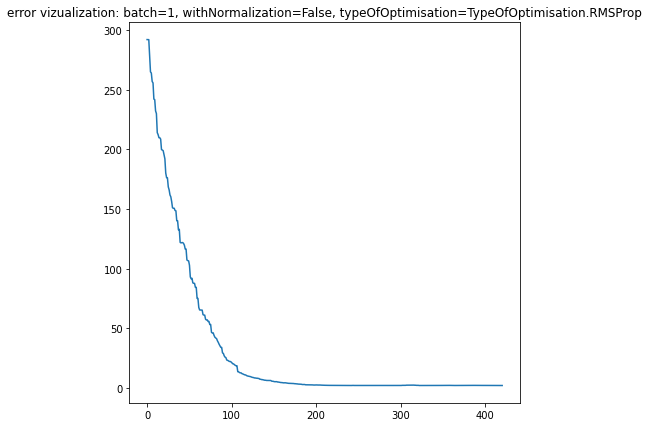

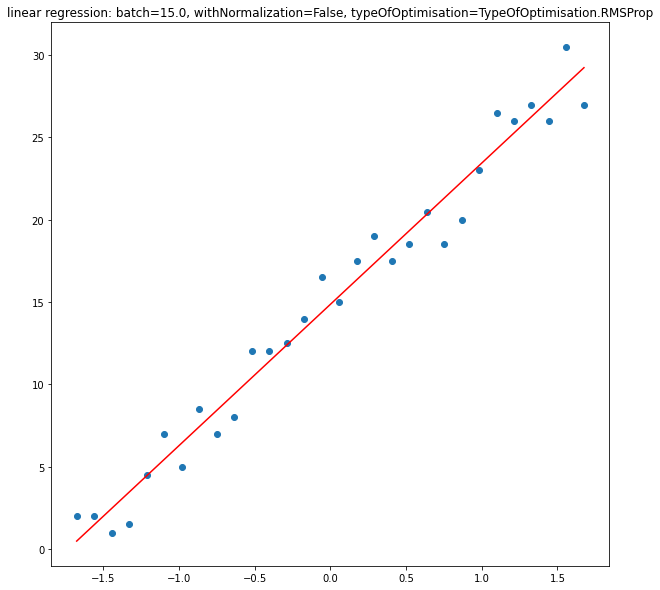

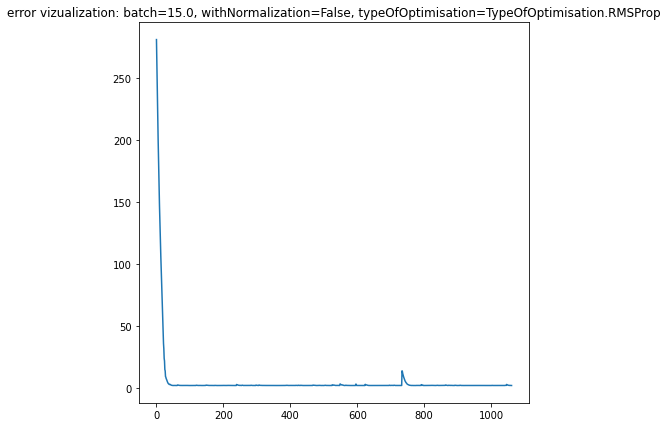

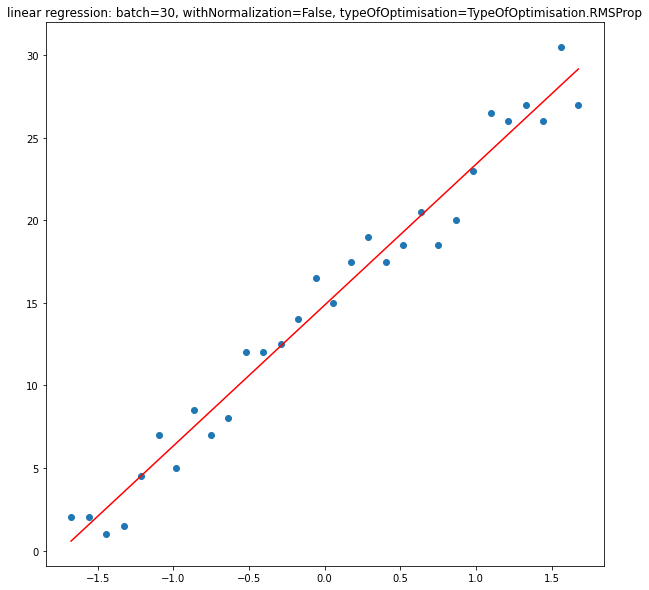

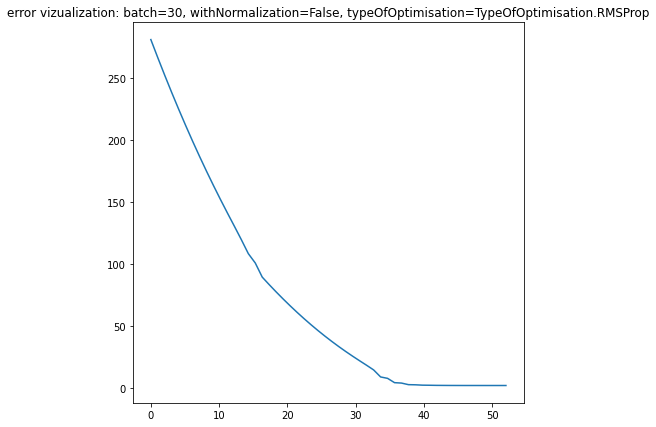

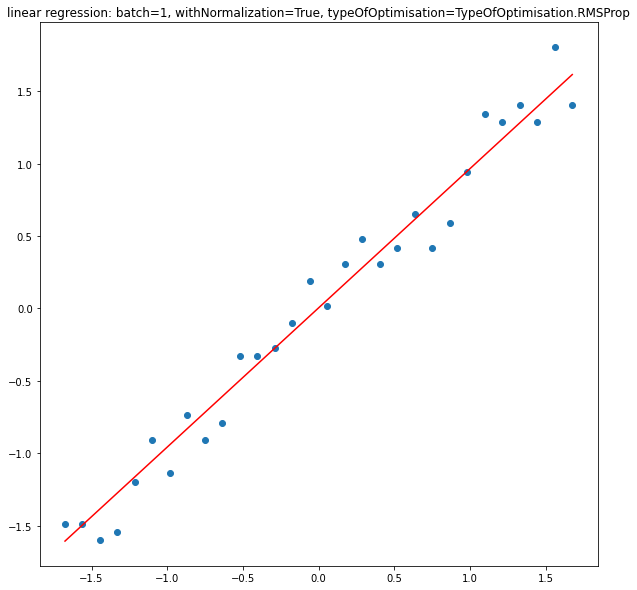

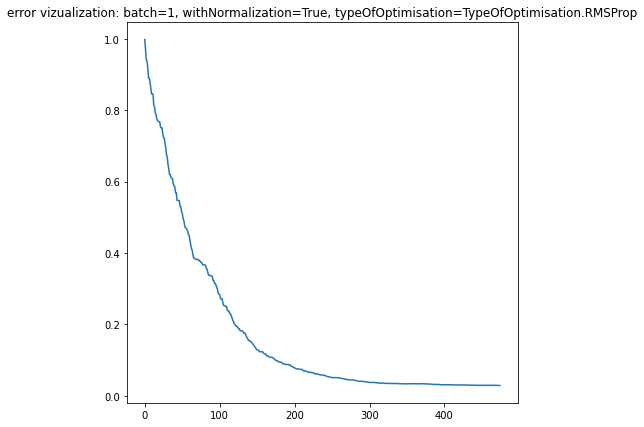

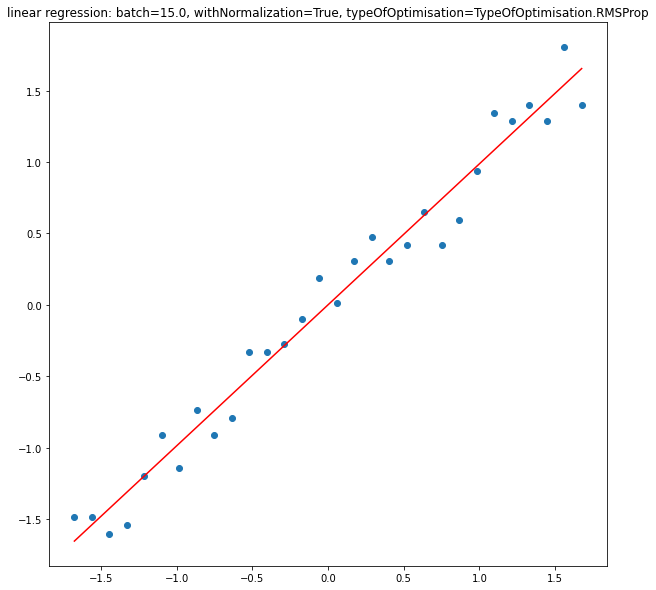

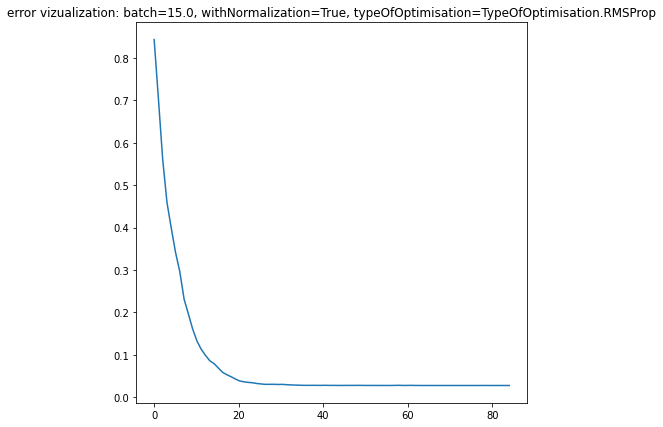

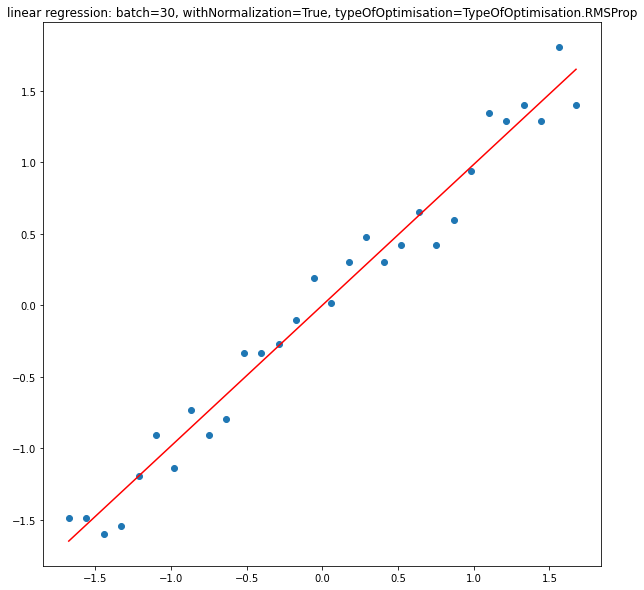

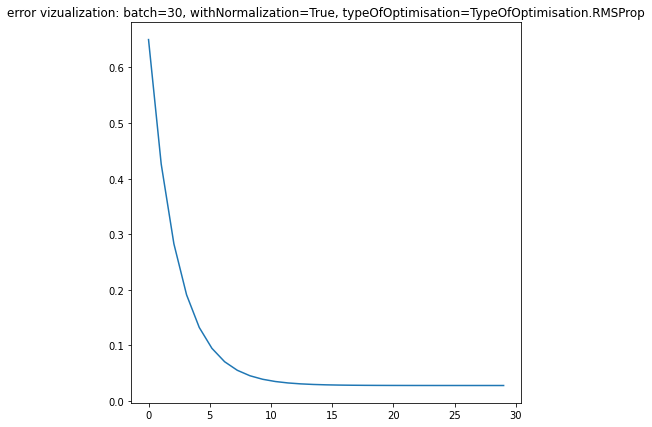

In [98]:
%memit runSGD(1, TypeOfOptimisation.RMSProp, withNormalization=False, lr=1e-1, eps=1e-5)
%memit runSGD(M / 2, TypeOfOptimisation.RMSProp, withNormalization=False, lr=1e-1, eps=1e-5)
%memit runSGD(M, TypeOfOptimisation.RMSProp, withNormalization=False, lr=1e-1, eps=1e-5)
%memit runSGD(1, TypeOfOptimisation.RMSProp, withNormalization=True, lr=1e-1, eps=1e-7)
%memit runSGD(M / 2, TypeOfOptimisation.RMSProp, withNormalization=True, lr=1e-1, eps=1e-6)
%memit runSGD(M, TypeOfOptimisation.RMSProp, withNormalization=True, lr=1e-1, eps=1e-6)


### Adam

Фактически, этот алгоритм является очередной модификацией алгоритма Adagrad, 
использующий сглаженные версии среднего и среднеквадратического градиентов


batch:                    1
294.69336960492035 2.09278286907314
actual coefficients:      [0. 1.]
calculated coefficients:  [14.79962631  8.46970766]
number of iterations:     456
number of calculations:  3199
execution time:  104.04086112976074 ms
peak memory: 124.42 MiB, increment: 0.00 MiB

batch:                    15.0
291.27317596388895 2.1088250685938883
actual coefficients:      [0. 1.]
calculated coefficients:  [14.71875425  8.48233866]
number of iterations:     298
number of calculations:  10465
execution time:  84.15913581848145 ms
peak memory: 124.42 MiB, increment: 0.00 MiB

batch:                    30
291.2731743609081 2.087235736527767
actual coefficients:      [0. 1.]
calculated coefficients:  [14.81220343  8.53413044]
number of iterations:     375
number of calculations:  24440
execution time:  150.4058837890625 ms
peak memory: 124.43 MiB, increment: 0.00 MiB

batch:                    1
0.9853962202255935 0.029630260855315286
actual coefficients:      [-1.  1.]
calc

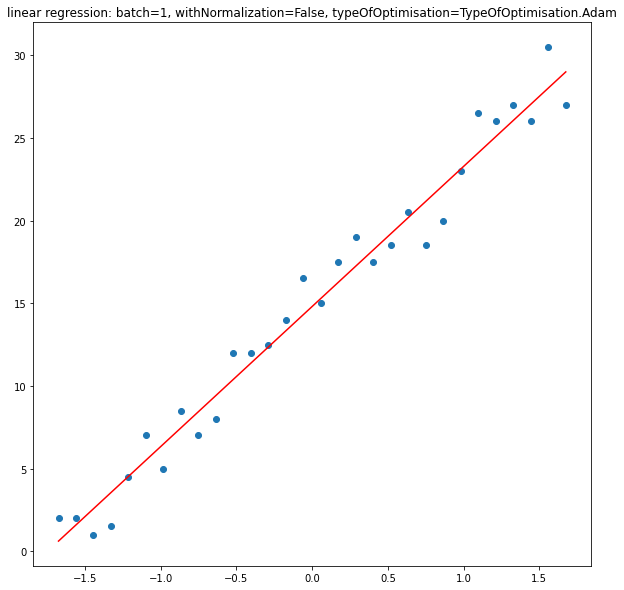

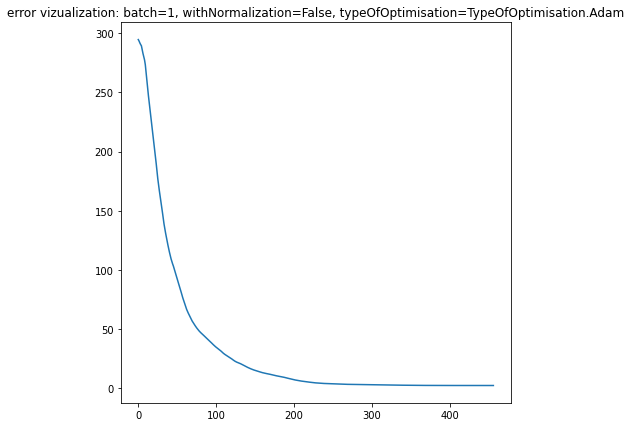

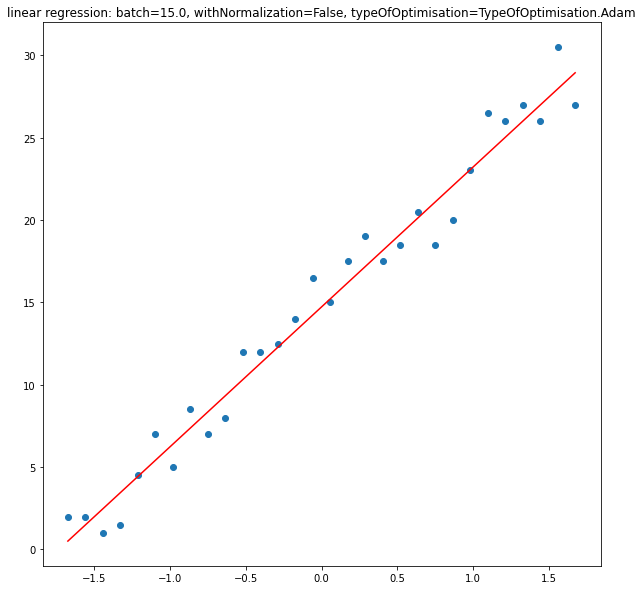

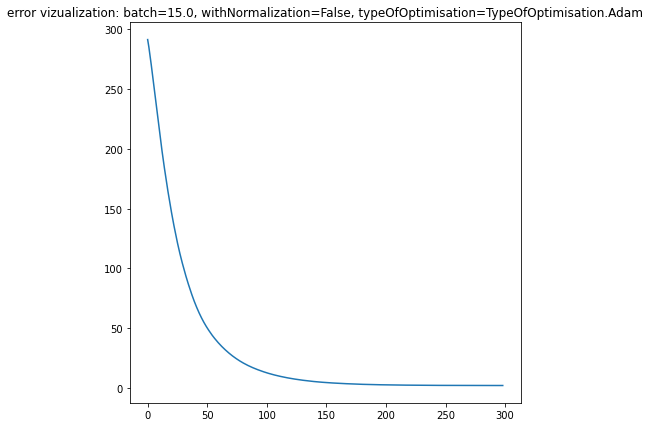

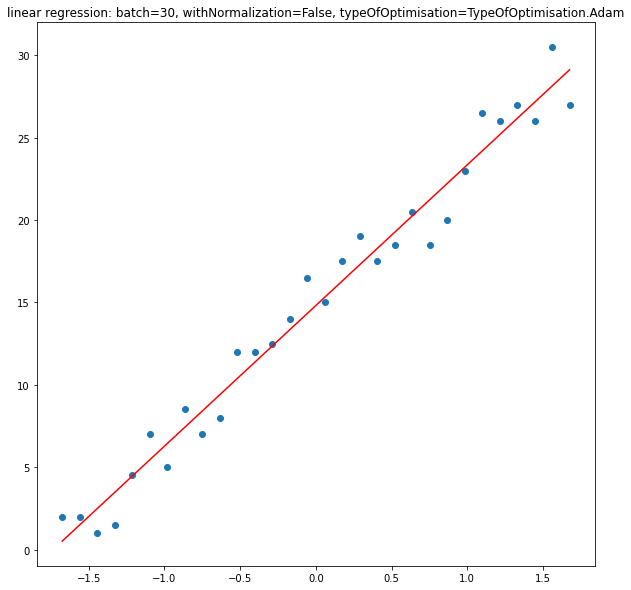

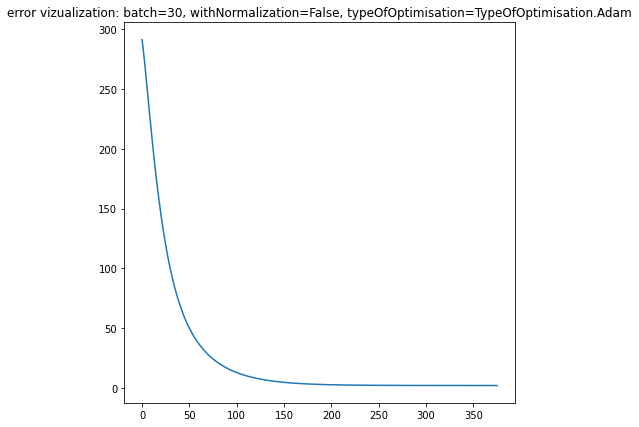

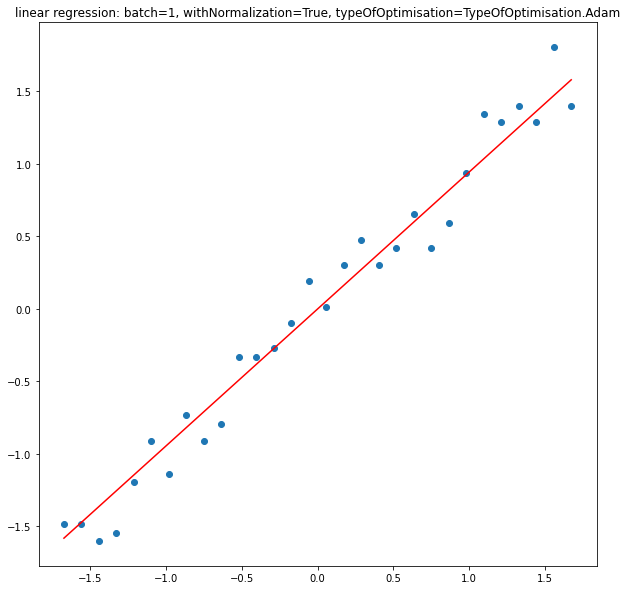

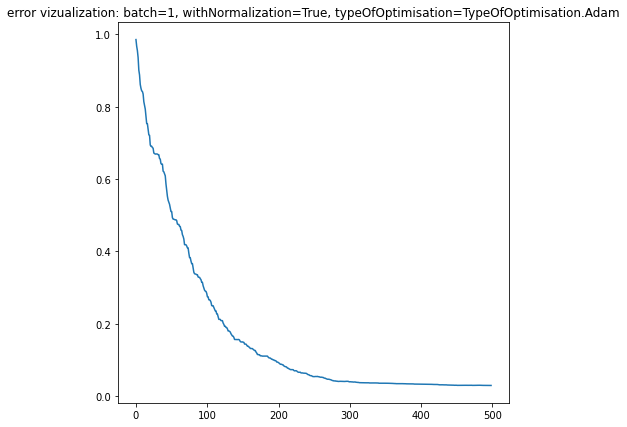

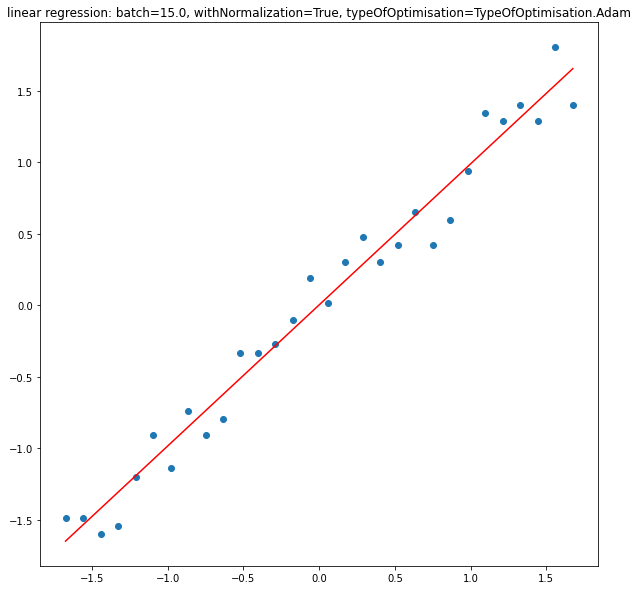

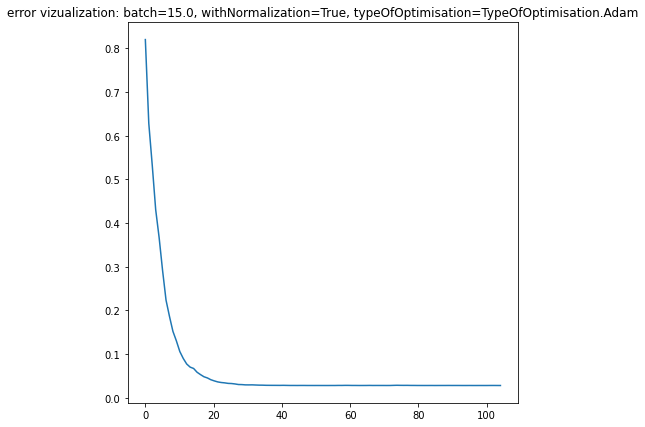

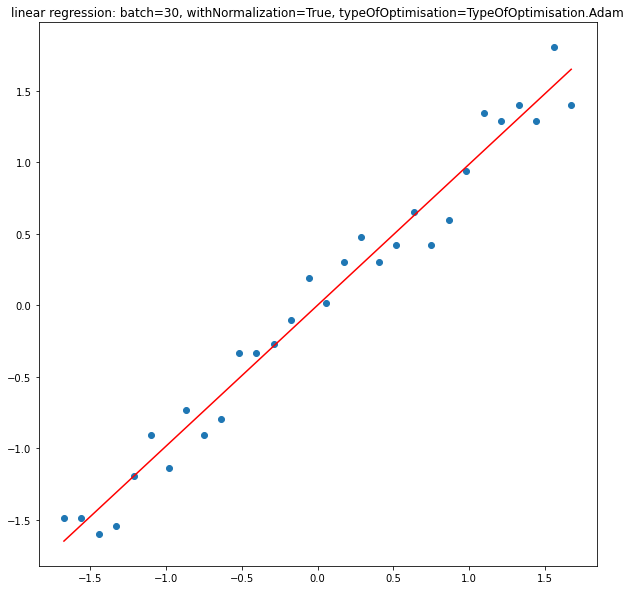

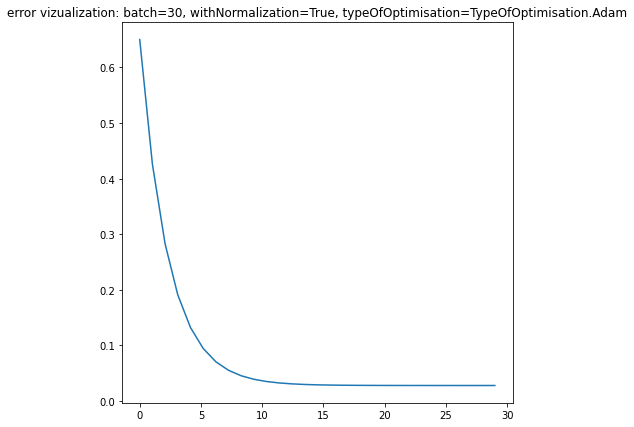

In [92]:
%memit runSGD(1, TypeOfOptimisation.Adam, withNormalization=False, lr=1e-1, eps=1e-4)
%memit runSGD(M / 2, TypeOfOptimisation.Adam, withNormalization=False, lr=1e-1, eps=1e-4)
%memit runSGD(M, TypeOfOptimisation.Adam, withNormalization=False, lr=1e-1, eps=1e-4)
%memit runSGD(1, TypeOfOptimisation.Adam, withNormalization=True, lr=1e-1, eps=1e-7)
%memit runSGD(M / 2, TypeOfOptimisation.Adam, withNormalization=True, lr=1e-1, eps=1e-6)
%memit runSGD(M, TypeOfOptimisation.Adam, withNormalization=True, lr=1e-1, eps=1e-6)

